#Object Detection Using RCNN
**CNN Model : VGG16-Pre Trained, , Bounding Box**

Artificial Neural Networks Course 1400-2  
Department of Computer Science, Shahid Beheshti University

Presented by Sara Charmchi  
Student ID : 400422066  
Advisor : Dr.Katanforoush  

## Ships in Satellite Imagery

Dataset: [Classify ships in San Franciso Bay using Planet satellite imagery](https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery)  

An implementation of RCNN algorithm for object detection using satellite imagery dataset based on the papaer : [Girshick et al., 2014](https://d2l.ai/chapter_references/zreferences.html#girshick-donahue-darrell-ea-2014)


In order to precisely locate the bounding box in the image., we used a scale-invariant linear regression model called bounding box regressor. For training this model we take as predicted and Ground truth pairs of four dimensions of localization. These dimensions are (x, y, w, h) where x and y are the pixel coordinates of center of bounding box respectively. w and h represents the width and height of bounding boxes.

for this reason we use the json file which that contains the entire dataset as .png image chips. Each individual image filename follows a specific format: {label} __ {scene id} __ {longitude} _ {latitude}.png

**processing each RoI for every image by a pretrained model such as the VGG16  takes alot of time even when we use the GPU.**

# Import Packages

In [ ]:
import json, sys, random
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
%matplotlib inline
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

#Load dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saracharmchi","key":"cd5bd2a72d556a3aac50896f2bdf8efd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery

 88% 163M/185M [00:01<00:00, 120MB/s] 
100% 185M/185M [00:01<00:00, 99.3MB/s]


In [ ]:
!ls

kaggle.json  satellite-imagery-of-ships.zip
sample_data  ships-in-satellite-imagery.zip


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r')
zip_ref.extractall('files_original')
zip_ref.close()

In [ ]:
!ls

files		kaggle.json  satellite-imagery-of-ships.zip
files_original	sample_data  ships-in-satellite-imagery.zip


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('satellite-imagery-of-ships.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
# download dataset from json object
np.random.seed(42)
f = open(r'/content/files_original/shipsnet.json')
dataset = json.load(f)
f.close()
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')
input_data.shape

(4000, 19200)

In [ ]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
y = to_categorical(output_data, 2)
indexes = np.arange(4000)
np.random.shuffle(indexes)
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]
X_train = X_train/255

In [ ]:
np.random.seed(42)
X_train.shape

(4000, 80, 80, 3)

#model

In [ ]:
#using a pre-trained model
from keras.layers import Input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import regularizers
model4 = VGG16(weights= None,include_top=False,input_tensor=Input(shape=(80,80, 3)))

#model4 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(80, 80, 3)))
input1 = Input(shape=(80,80,3),name = 'image_input')

output_vgg16_conv = model4(input1)


#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(2, activation='softmax', name='predictions')(x)



#Create your own model 
my_model = Model(inputs = input1, outputs = x)
#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()
#saving the model and model weights for convolution network with dropout
from keras.models import load_model
my_model.save('my_model_VGG.h5')  # creates a HDF5 file 'my_model.h5'
my_model.save_weights('my_model_VGG_weights.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 80, 80, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 fc1 (Dense)                 (None, 128)               262272    
                                                                 
 predictions (Dense)         (None, 2)                 258       
                                                                 
Total params: 14,977,218
Trainable params: 14,977,218
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimization setup
import tensorflow
opt2 = tensorflow.optimizers.Adam(learning_rate=10e-02, beta_1=0.9, beta_2=0.999, amsgrad=False)
#opt = tensorflow.optimizers.Adam(learning_rate=1e-4)
my_model.compile(
    loss='binary_crossentropy',
    optimizer=opt2,
    metrics=['accuracy'])

# training
history=my_model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=25,
    validation_split=0.2,
    shuffle=True,
    verbose=1)


Epoch 1/25
 42/100 [===========>..................] - ETA: 8:01 - loss: 2665486390711549952.0000 - accuracy: 0.5439

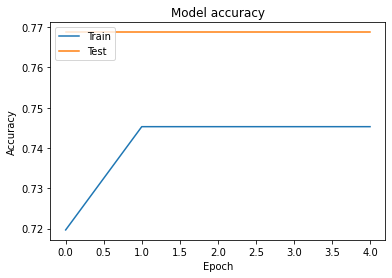

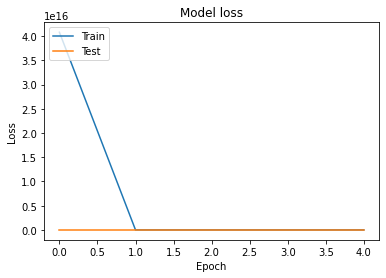

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#end model

In [ ]:
image = Image.open('/content/files_original/scenes/scenes/sfbay_1.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]

#Predict

In [ ]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

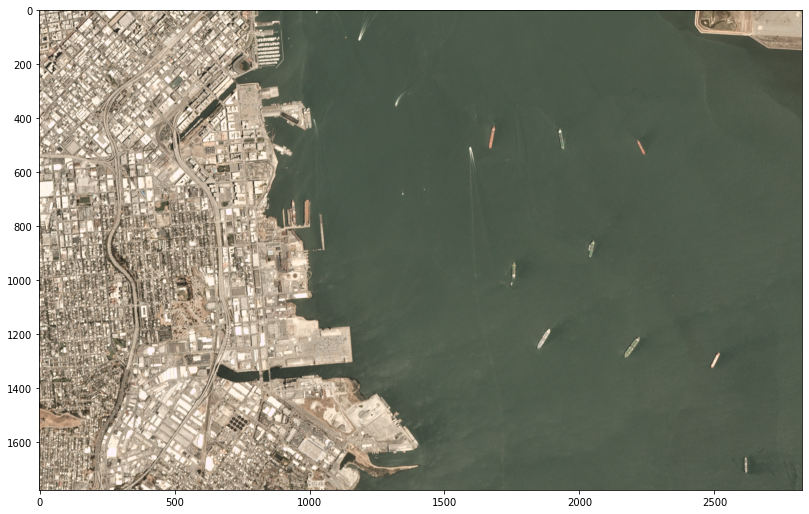

In [ ]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [ ]:
picture_tensor = picture_tensor.transpose(2,0,1)

In [ ]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [ ]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [ ]:
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

In [ ]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = my_model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [ ]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [ ]:
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape
(1777, 2825, 3)


(1777, 2825, 3)

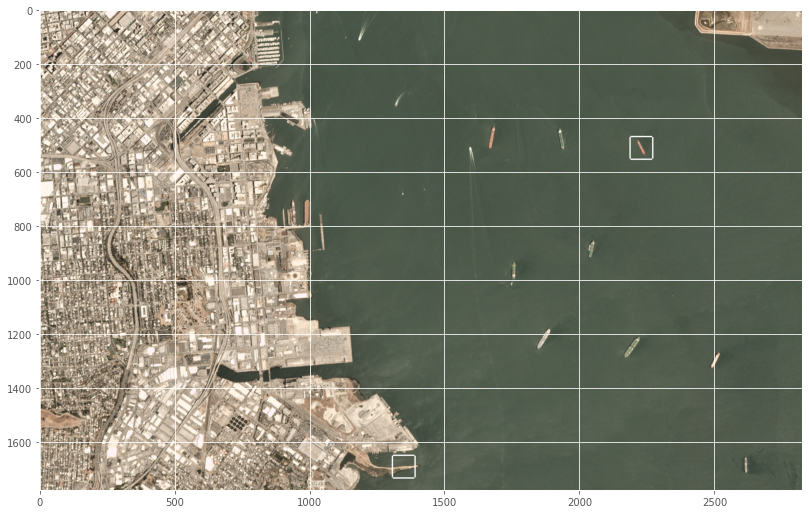

In [ ]:
#With Dropout
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()